## Benchmark between Signatory and Signax

This is just a rough comparison. 

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import signatory
import torch
from signax.signature import signature

# set white background
plt.rcParams["figure.facecolor"] = "white" 

In [2]:
class Runner:
    size: tuple
    depth: int
    platform: str

    def __init__(self, size, depth, platform) -> None:
        self.size = size
        self.depth = depth
        self.platform = platform

    def setup(self):
        assert len(self.size) == 3
        assert self.depth > 0
        assert self.platform == "cpu" or self.platform == "gpu"

        path = np.random.randn(*self.size)

        # setup for JAX
        jax.config.update("jax_platform_name", self.platform)
        self.jax_path = jnp.array(path)

        # set up for torch
        if self.platform == "cpu":
            device = torch.device("cpu")
        else:
            assert torch.cuda.is_available()
            device = torch.device("cuda")

        self.torch_path = torch.tensor(path).to(device).requires_grad_(True)

    def run_jax(self, func):
        func(self.jax_path, self.depth)

    def run_torch(self, func):
        func(self.torch_path, self.depth)

### Function we want to test

In [3]:
def jax_signature(X, depth):
    result = jax.vmap(lambda x: signature(x, depth))(X)
    [x.block_until_ready() for x in result]


def torch_signature(X, depth):
    signatory.signature(X, depth)


def jax_signature_backward(X, depth):
    def _fn(x):
        sig = signature(x, depth)
        return sum(map(jnp.sum, sig))

    def _fn_batch(batch_x):
        return jnp.sum(jax.vmap(_fn)(batch_x))

    value, grad = jax.value_and_grad(_fn_batch)(X)
    value.block_until_ready()
    grad.block_until_ready()


def torch_signature_backward(X, depth):
    sig = signatory.signature(X.requires_grad_(True), depth)
    loss = torch.sum(sig)
    loss.backward()

### Typical case with GPU

In [4]:
size = (32, 128, 8)
depth = 5
platform = "gpu"

In [5]:
runner1 = Runner(size=size, depth=depth, platform=platform)
runner1.setup()

In [6]:
%%timeit -o
runner1.run_jax(jax_signature)

6.59 ms ± 97.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 6.59 ms ± 97.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [7]:
result_jax = _  # noqa: F821

In [8]:
%%timeit -o
runner1.run_torch(torch_signature)

15.8 ms ± 873 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


<TimeitResult : 15.8 ms ± 873 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [9]:
result_torch = _  # noqa: F821

In [10]:
%%timeit -o
runner1.run_jax(jax_signature_backward)

47.4 ms ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 47.4 ms ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [11]:
result_jax_backward = _  # noqa: F821

In [12]:
%%timeit -o
runner1.run_torch(torch_signature_backward)

93.6 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 93.6 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [13]:
result_torch_backward = _  # noqa: F821

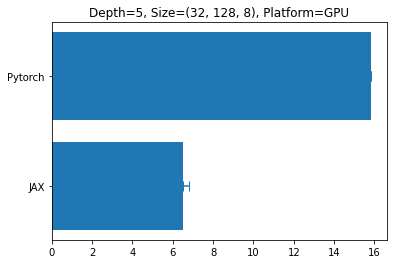

In [14]:
names = ["JAX", "Pytorch"]

results = np.array(
    [
        1e3 * np.min(result_jax.all_runs) / result_jax.loops,
        1e3 * np.min(result_torch.all_runs) / result_torch.loops,
    ]
)

variations = np.array(
    [
        1e3 * np.ptp(result_jax.all_runs) / result_jax.loops,
        1e3 * np.ptp(result_torch.all_runs) / result_torch.loops,
    ]
)

fig, ax = plt.subplots()
ax.barh(range(2), results)
ax.errorbar(
    results + variations / 2,
    range(2),
    xerr=variations / 2,
    capsize=5,
    fmt="none",
)
ax.set_title(f"Depth={depth}, Size={size}, Platform={platform.upper()}")
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
fig.savefig("../assets/forward_gpu.png", dpi=256)

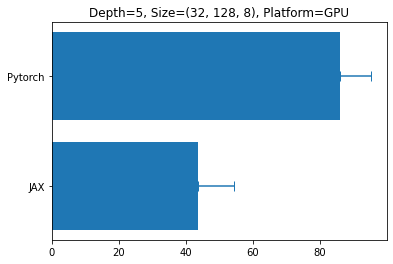

In [15]:
results = np.array(
    [
        1e3
        * np.min(result_jax_backward.all_runs)
        / result_jax_backward.loops,  # noqa: E501
        1e3
        * np.min(result_torch_backward.all_runs)
        / result_torch_backward.loops,  # noqa: E501
    ]
)

variations = np.array(
    [
        1e3 * np.ptp(result_jax_backward.all_runs) / result_jax_backward.loops,
        1e3
        * np.ptp(result_torch_backward.all_runs)
        / result_torch_backward.loops,  # noqa: E501
    ]
)

fig, ax = plt.subplots()
ax.barh(range(2), results)
ax.errorbar(
    results + variations / 2,
    range(2),
    xerr=variations / 2,
    capsize=5,
    fmt="none",
)
ax.set_title(f"Depth={depth}, Size={size}, Platform={platform.upper()}")
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
fig.savefig("../assets/backward_gpu.png", dpi=256)

### Typical case with CPU

NOTE: The below result is done by restarting the notebook and skipping GPU setting because JAX does not reload the platform

In [4]:
size = (32, 128, 8)
depth = 5
platform = "cpu"

jax.config.update("jax_platform_name", platform)

In [5]:
runner1 = Runner(size=size, depth=depth, platform=platform)
runner1.setup()

In [6]:
%%timeit -o
runner1.run_jax(jax_signature)

31.8 ms ± 2.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 31.8 ms ± 2.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [7]:
result_jax = _  # noqa: F821

In [8]:
%%timeit -o
runner1.run_torch(torch_signature)

47.9 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 47.9 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [9]:
result_torch = _  # noqa: F821

In [10]:
%%timeit -o
runner1.run_jax(jax_signature_backward)

222 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 222 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [11]:
result_jax_backward = _  # noqa: F821

In [12]:
%%timeit -o
runner1.run_torch(torch_signature_backward)

513 ms ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 513 ms ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [13]:
result_torch_backward = _  # noqa: F821

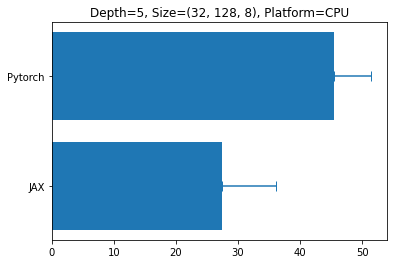

In [14]:
names = ["JAX", "Pytorch"]

results = np.array(
    [
        1e3 * np.min(result_jax.all_runs) / result_jax.loops,
        1e3 * np.min(result_torch.all_runs) / result_torch.loops,
    ]
)

variations = np.array(
    [
        1e3 * np.ptp(result_jax.all_runs) / result_jax.loops,
        1e3 * np.ptp(result_torch.all_runs) / result_torch.loops,
    ]
)

fig, ax = plt.subplots()
ax.barh(range(2), results)
ax.errorbar(
    results + variations / 2,
    range(2),
    xerr=variations / 2,
    capsize=5,
    fmt="none",
)
ax.set_title(
    f"Depth={depth}, \
    Size={size}, \
        Platform={platform.upper()}"
)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
fig.savefig("../assets/forward_cpu.png", dpi=256)

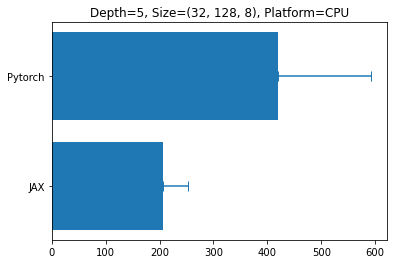

In [15]:
results = np.array(
    [
        1e3
        * np.min(result_jax_backward.all_runs)
        / result_jax_backward.loops,  # noqa: E501
        1e3
        * np.min(result_torch_backward.all_runs)
        / result_torch_backward.loops,  # noqa: E501
    ]
)

variations = np.array(
    [
        1e3
        * np.ptp(result_jax_backward.all_runs)
        / result_jax_backward.loops,  # noqa: E501
        1e3
        * np.ptp(result_torch_backward.all_runs)
        / result_torch_backward.loops,  # noqa: E501
    ]
)

fig, ax = plt.subplots()
ax.barh(range(2), results)
ax.errorbar(
    results + variations / 2,
    range(2),
    xerr=variations / 2,
    capsize=5,
    fmt="none",
)
ax.set_title(
    f"Depth={depth}, \
    Size={size}, \
        Platform={platform.upper()}"
)  # noqa: E501
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
fig.savefig("../assets/backward_cpu.png", dpi=256)